#  검색 성능 향상을 위한 기법 

- 키워드 검색 / 하이브리드 검색

### **학습 목표:** 키워드 검색과 하이브리드 검색 방식을 실습하고 비교 분석한다

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob

from pprint import pprint
import json

`(3) langfuase handler 설정`

In [3]:
from langfuse.callback import CallbackHandler

# LangChain 콜백 핸들러 생성
langfuse_handler = CallbackHandler()

# 정상 작동 확인
langfuse_handler.auth_check() 

ModuleNotFoundError: No module named 'langfuse.callback'

---

## RAG 검색기

1. **의미론적 검색 (Semantic Search)**
    - Vector Store를 기반으로 한 검색 방식으로, 텍스트의 의미적 유사성을 고려하여 검색을 수행함
    - 임베딩 벡터 간의 유사도를 계산하여 의미적으로 관련성이 높은 문서를 찾아내는 특징이 있음
    - 동의어나 문맥적 의미를 파악할 수 있어 자연어 질의에 효과적임

1. **키워드 검색 (Keyword Search)**
    - BM25와 같은 전통적인 검색 알고리즘을 사용하여 키워드 매칭을 기반으로 검색을 수행함
    - 정확한 단어나 구문 매칭에 강점이 있으며, 계산 효율성이 높은 특징을 가짐
    - 직접적인 키워드 일치를 찾는 데 유용하나, 의미적 유사성을 파악하는 데는 한계가 있음

1. **하이브리드 검색 (Hybrid Search)**
    - 키워드 기반 검색과 의미론적 검색을 결합한 방식으로, EnsembleRetriever를 통해 구현됨
    - 두 검색 방식의 장점을 활용하여 더 정확하고 포괄적인 검색 결과를 제공함
    - 정확한 키워드 매칭과 의미적 연관성을 모두 고려하여 검색 성능을 향상시키는 특징이 있음

### 1) **Semantic Search** (의미론적 검색) 

- **의미론적 검색**은 텍스트의 **벡터 표현**을 활용해 의미적 유사성 기반 검색 수행
- **Vector Store**에 저장된 임베딩 벡터 간 **유사도 계산**으로 관련 문서 검색
- 검색어와 문서 간의 **문맥적 의미**와 **동의어 관계**를 효과적으로 파악
- **자연어 질의**에 강점을 보이며 기존 키워드 검색의 한계를 보완
- 전통적인 검색 방식과 달리 **의미 기반 매칭**으로 더 정확하고 포괄적인 검색 결과 제공

`(1) 벡터 저장소 초기화`
- cosine distance 기준으로 인덱싱 

In [4]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 데이터 로드
def load_text_files(txt_files):
    data = []

    for text_file in txt_files:
        loader = TextLoader(text_file, encoding='utf-8')
        data += loader.load()

    return data

korean_txt_files = glob(os.path.join('data', '*_KR.md')) 
korean_data = load_text_files(korean_txt_files)

# 문장을 구분하여 분할 - 정규표현식 사용 (문장 구분자: 마침표, 느낌표, 물음표 다음에 공백이 오는 경우)
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base",    # TikToken 인코더 이름
    separators=['\n\n', '\n', r'(?<=[.!?])\s+'],   # 구분자
    chunk_size=300,            # 문서 분할 크기
    chunk_overlap=50,          # 문서 분할 중첩  
    is_separator_regex=True,      # 구분자가 정규식인지 여부
    keep_separator=True,          # 구분자 유지 여부
)

korean_chunks = text_splitter.split_documents(korean_data)

print("한국어 청크 수:", len(korean_chunks))

한국어 청크 수: 39


In [5]:
for i, doc in enumerate(korean_chunks):
    print(f"[{i}]", doc.page_content)
    print("="*200)

[0] Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:**
[1] - **회사 유형:** 상장
- **거래소:** NASDAQ: RIVN
- **설립:** 2009년 6월, 플로리다 주 록ledge
- **설립자:** R. J. 스캐린지
- **본사:** 미국 캘리포니아 주 어바인
- **서비스 지역:** 북미
- **주요 인물:** R. J. 스캐린지 (CEO)
- **제품:** 전기 자동차, 배터리
- **생산량 (2023):** 57,232대
- **서비스:** 전기 자동차 충전, 자동차 보험
- **수익 (2023):** 44억 3천만 미국 달러
- **순이익 (2023):** -54억 미국 달러
- **총 자산 (2023):** 168억 미국 달러
[2] - **총 자산 (2023):** 168억 미국 달러
- **총 자본 (2023):** 91억 4천만 미국 달러
- **직원 수 (2023년 12월):** 16,790명
- **웹사이트:** rivian.com
[3] **개요**

Rivian은 "스케이트보드" 플랫폼(R1T 및 R1S 모델)을 기반으로 한 전기 스포츠 유틸리티 차량(SUV), 픽업 트럭 및 전기 배달 밴(Rivian EDV)을 생산합니다. R1T 배송은 2021년 말에 시작되었습니다. 회사는 2022년에 미국에서 충전 네트워크를 시작하여 2024년에 다른 차량에도 개방했습니다. 생산 공장은 일리노이 주 노멀에 있으며, 다른 시설은 미국, 캐나다, 영국 및 세르비아의 여러 주에 있습니다.

**역사**

**초창기 (2009–15):**
[4] **역사**

**초창기 (2009–15):**

- 2009년 R. J. 스캐린지가 Mainstream Motors로 설립.
- 2011년 Rivian Automotive로 사명 변경.
- 처음에는 스포츠카 프로토타입(R1)에 집중했지만 전기 및 자율 주행 차량으로 전환.

**생산

In [8]:
from langchain_core.documents import Document
# Document 객체에 메타데이터 추가


korean_docs = []

for chunk in korean_chunks:
    doc = Document(page_content=chunk.page_content, metadata=chunk.metadata)
    doc.metadata['company'] = '테슬라' if '테슬라' in doc.metadata['source'] else '리비안'
    doc.metadata['language'] = 'ko'
    doc.page_content = f"[출처] 이 문서는 {doc.metadata['company']}에 대한 문서입니다.\n----------------------------------\n{doc.page_content}"
    korean_docs.append(doc)

print("한국어 문서 수:", len(korean_docs))
print(korean_docs[0].metadata)
print(korean_docs[-1].metadata)
print("="*200)
print(korean_docs[0].page_content)

한국어 문서 수: 39
{'source': 'data\\리비안_KR.md', 'company': '리비안', 'language': 'ko'}
{'source': 'data\\테슬라_KR.md', 'company': '테슬라', 'language': 'ko'}
[출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:**


In [7]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

# OpenAI Embeddings 모델을 로드
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Chroma 벡터 저장소 생성하기
chroma_db = Chroma.from_documents(
    documents=korean_docs,
    embedding=embeddings,    
    collection_name="db_korean_cosine_metadata", 
    persist_directory="./chroma_db",
    collection_metadata = {'hnsw:space': 'cosine'}, # l2, ip, cosine 중에서 선택 
)

`(2) 벡터 저장소 로드`
- 미리 인덱싱해서 저장해 둔 저장소를 가져와서 사용
- 이때 기존에 사용한 임베딩 모델을 초기화 필요

In [9]:
# 벡터 저장소 로드 
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

chroma_db = Chroma(
    collection_name="db_korean_cosine_metadata",
    embedding_function=embeddings,
    persist_directory="./chroma_db",
)

`(3) Semantic Search 실행`
- 벡터 저장소 검색기 객체 활용
- 임베딩 벡터 간의 유사도를 기반으로 문서 검색

In [10]:
# 검색기 지정하여 테스트 
chroma_k_retriever = chroma_db.as_retriever(
    search_kwargs={"k": 2},
)

query = "리비안은 언제 사업을 시작했나요?"
retrieved_docs = chroma_k_retriever.invoke(query)

for doc in retrieved_docs:
    print(f"{doc.page_content} [출처: {doc.metadata['source']}]")
    print("="*200)

[출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
- **회사 유형:** 상장
- **거래소:** NASDAQ: RIVN
- **설립:** 2009년 6월, 플로리다 주 록ledge
- **설립자:** R. J. 스캐린지
- **본사:** 미국 캘리포니아 주 어바인
- **서비스 지역:** 북미
- **주요 인물:** R. J. 스캐린지 (CEO)
- **제품:** 전기 자동차, 배터리
- **생산량 (2023):** 57,232대
- **서비스:** 전기 자동차 충전, 자동차 보험
- **수익 (2023):** 44억 3천만 미국 달러
- **순이익 (2023):** -54억 미국 달러
- **총 자산 (2023):** 168억 미국 달러 [출처: data\리비안_KR.md]
[출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:** [출처: data\리비안_KR.md]


### 2) **Keyword Search** (키워드 검색) 

- **키워드 검색**은 **BM25** 등 전통적 알고리즘 기반의 단어 매칭 방식
- 정확한 **단어/구문 매칭**에 강점이 있으며 **계산 효율성**이 우수함
- **직접적인 키워드** 검색에는 효과적이나 의미적 연관성 파악에는 제한적
- 구현이 단순하고 **처리 속도가 빠르다**는 장점이 있음
- 정확한 키워드 매칭이 필요한 경우에 적합하나 **의미론적 검색의 보완**이 필요함

`(1) BM25 검색기 생성`

- BM25: TF-IDF (Term Frequency-Inverse Document Frequency)의 확장된 버전
- `rank_bm25` 설치

In [11]:
# 벡터 저장소에 저정한 문서 객체를 로드하여 확인
chroma_db.get().keys()

dict_keys(['ids', 'embeddings', 'documents', 'uris', 'included', 'data', 'metadatas'])

In [12]:
# BM25 검색기 생성을 위해 문서 객체를 로드
documents = chroma_db.get()["documents"]
metadatas = chroma_db.get()["metadatas"]

# Document 객체로 변환
from langchain_core.documents import Document
docs = [Document(page_content=content, metadata=meta) for content, meta in zip(documents, metadatas)]

print("문서의 수:" , len(docs))
print("=" * 200)
for doc in docs[:3]:
    print(f"{doc.page_content} [출처: {doc.metadata['source']}]")
    print("-" * 200)

문서의 수: 39
[출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:** [출처: data\리비안_KR.md]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
- **회사 유형:** 상장
- **거래소:** NASDAQ: RIVN
- **설립:** 2009년 6월, 플로리다 주 록ledge
- **설립자:** R. J. 스캐린지
- **본사:** 미국 캘리포니아 주 어바인
- **서비스 지역:** 북미
- **주요 인물:** R. J. 스캐린지 (CEO)
- **제품:** 전기 자동차, 배터리
- **생산량 (2023):** 57,232대
- **서비스:** 전기 자동차 충전, 자동차 보험
- **수익 (2023):** 44억 3천만 미국 달러
- **순이익 (2023):** -54억 미국 달러
- **총 자산 (2023):** 168억 미국 달러 [출처: data\리비안_KR.md]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
from langchain_community.retrievers import BM25Retriever

# BM25 검색기 생성
bm25_retriever = BM25Retriever.from_documents(docs)

# BM25 검색기를 사용하여 검색
query = "리비안은 언제 사업을 시작했나요?"

retrieved_docs = bm25_retriever.invoke(query)

for doc in retrieved_docs:
    print(f"- {doc.page_content} [출처: {doc.metadata['source']}]")
    print("="*200)

- [출처] 이 문서는 테슬라에 대한 문서입니다.
----------------------------------
## 파트너

Tesla는 Panasonic과 파트너십을 맺고 있으며 리튬 공급에 대한 장기 계약을 맺고 있습니다. 이전 파트너로는 Daimler와 Toyota가 있습니다.

## 소송 및 논란

Tesla는 성희롱, 노동 분쟁, 사기 혐의, 대리점 분쟁, 지적 재산권, 환경 위반, 재산 피해, 인종 차별, COVID-19 팬데믹 대응 및 수리 권리와 관련된 소송 및 논란에 직면했습니다.

## 비판

Tesla는 데이터 개인 정보 보호, 공매도자, 지연, 차량 제품 문제, 화재, Autopilot 충돌, 소프트웨어 해킹, 가상 제동 및 주행 거리 성능과 관련된 비판에 직면했습니다. [출처: data\테슬라_KR.md]
- [출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
**시설**

- **Irvine, California:** 차량 엔지니어링 및 설계에 중점을 둔 본사.
- **Normal, Illinois:** 차량 부품을 생산하고 조립을 수행하는 제조 공장.
- **Plymouth, Michigan:** 차량 엔지니어링, 프로토타입 제작, 공급망 및 회계에 중점을 둡니다.
- **Palo Alto, California:** 소프트웨어 개발 및 엔지니어링에 중점을 둡니다.
- Carson, California 및 Woking, England에 추가 사무실이 있습니다.
- 애틀랜타 동쪽에 있는 새로운 50억 달러 규모의 배터리 및 조립 공장은 보류 중입니다.

**재정**

Rivian의 재무 성과는 상당한 수익 성장과 상당한 순손실로 특징지어집니다. [출처: data\리비안_KR.md]
- [출처] 이 문서는 테슬라에 대한 문서입니다.
----------------------------------
Roadster 생산은 2008년에 시작되었습니다. 2009년 1월까지 Tesla는 1억

In [14]:
# BM25 점수를 확인 - "리비안은" 라는 단어가 쿼리에 포함되어 있지 않아 검색 결과가 없음
query = "리비안은 언제 사업을 시작했나요?"
tokenized_query = query.split()
print(tokenized_query)
print("="*200)

# 문서의 BM25 점수 확인
doc_scores = bm25_retriever.vectorizer.get_scores(tokenized_query)

# 문서의 BM25 점수를 내림차순으로 정렬
doc_scores_sorted = sorted(enumerate(doc_scores), key=lambda x: x[1], reverse=True)

# 상위 5개 문서의 인덱스와 점수를 출력
for idx, score in doc_scores_sorted[:5]:
    print(f"[{idx}] {docs[idx].page_content}")
    print(f"BM25 Score: {score}")
    print("-"*200)

['리비안은', '언제', '사업을', '시작했나요?']
[0] [출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:**
BM25 Score: 0.0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[1] [출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
- **회사 유형:** 상장
- **거래소:** NASDAQ: RIVN
- **설립:** 2009년 6월, 플로리다 주 록ledge
- **설립자:** R. J. 스캐린지
- **본사:** 미국 캘리포니아 주 어바인
- **서비스 지역:** 북미
- **주요 인물:** R. J. 스캐린지 (CEO)
- **제품:** 전기 자동차, 배터리
- **생산량 (2023):** 57,232대
- **서비스:** 전기 자동차 충전, 자동차 보험
- **수익 (2023):** 44억 3천만 미국 달러
- **순이익 (2023):** -54억 미국 달러
- **총 자산 (2023):** 168억 미국 달러
BM25 Score: 0.0
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
# 같은 의미를 갖는 쿼리로 변경하여 다시 검색 
query = "리비안이 설립된 연도는?"

retrieved_docs = bm25_retriever.invoke(query)

for doc in retrieved_docs:
    print(f"- {doc.page_content} [출처: {doc.metadata['source']}]")
    print("="*200)

- [출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:** [출처: data\리비안_KR.md]
- [출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
**시설**

- **Irvine, California:** 차량 엔지니어링 및 설계에 중점을 둔 본사.
- **Normal, Illinois:** 차량 부품을 생산하고 조립을 수행하는 제조 공장.
- **Plymouth, Michigan:** 차량 엔지니어링, 프로토타입 제작, 공급망 및 회계에 중점을 둡니다.
- **Palo Alto, California:** 소프트웨어 개발 및 엔지니어링에 중점을 둡니다.
- Carson, California 및 Woking, England에 추가 사무실이 있습니다.
- 애틀랜타 동쪽에 있는 새로운 50억 달러 규모의 배터리 및 조립 공장은 보류 중입니다.

**재정**

Rivian의 재무 성과는 상당한 수익 성장과 상당한 순손실로 특징지어집니다. [출처: data\리비안_KR.md]
- [출처] 이 문서는 테슬라에 대한 문서입니다.
----------------------------------
Roadster 생산은 2008년에 시작되었습니다. 2009년 1월까지 Tesla는 1억 8,700만 달러를 모금하고 147대의 자동차를 인도했습니다. 2009년 6월, Tesla는 미국 에너지부로부터 4억 6,500만 달러의 대출을 받았으며, 2013년 5월에 이자와 함께 상환했습니다.

### IPO, Model S 및 Model X (2010–2015)

2010년 5월, Tesla는 캘리포니아 주 프리몬트의 NUMMI 공장을 Toyota로부터 인수했습니다. 이 회사는 2010년 6월 NASDAQ에 상장하

In [16]:
# BM25 점수를 확인 - "리비안이" 라는 단어가 쿼리에 포함되어 있어 검색 결과가 있음
query = "리비안이 설립된 연도는?"
tokenized_query = query.split()
print(tokenized_query)
print("="*200)

# 문서의 BM25 점수 확인
doc_scores = bm25_retriever.vectorizer.get_scores(tokenized_query)

# 문서의 BM25 점수를 내림차순으로 정렬
doc_scores_sorted = sorted(enumerate(doc_scores), key=lambda x: x[1], reverse=True)

# 상위 5개 문서의 인덱스와 점수를 출력
for idx, score in doc_scores_sorted[:5]:
    print(f"[{idx}] {docs[idx].page_content}")
    print(f"BM25 Score: {score}")
    print("-"*200)

['리비안이', '설립된', '연도는?']
[0] [출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:**
BM25 Score: 4.606669099813676
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[1] [출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
- **회사 유형:** 상장
- **거래소:** NASDAQ: RIVN
- **설립:** 2009년 6월, 플로리다 주 록ledge
- **설립자:** R. J. 스캐린지
- **본사:** 미국 캘리포니아 주 어바인
- **서비스 지역:** 북미
- **주요 인물:** R. J. 스캐린지 (CEO)
- **제품:** 전기 자동차, 배터리
- **생산량 (2023):** 57,232대
- **서비스:** 전기 자동차 충전, 자동차 보험
- **수익 (2023):** 44억 3천만 미국 달러
- **순이익 (2023):** -54억 미국 달러
- **총 자산 (2023):** 168억 미국 달러
BM25 Score: 0.0
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

`(2) kiwi 한국어 토크나이저`
- `kiwipiepy` 설치 필요 (pip install kiwipiepy / poetry add kiwipiepy)

In [17]:
# 한국어 토크나이저를 사용하여 문장을 토큰화
from kiwipiepy import Kiwi

kiwi = Kiwi()

print(kiwi.analyze("리비안은 언제 사업을 시작했나요?"))
print("="*200)
print(kiwi.analyze("리비안이 설립된 연도는?"))

[([Token(form='리비아', tag='NNP', start=0, len=3), Token(form='ᆫ', tag='JX', start=2, len=1), Token(form='은', tag='JX', start=3, len=1), Token(form='언제', tag='MAG', start=5, len=2), Token(form='사업', tag='NNG', start=8, len=2), Token(form='을', tag='JKO', start=10, len=1), Token(form='시작', tag='NNG', start=12, len=2), Token(form='하', tag='XSV', start=14, len=1), Token(form='었', tag='EP', start=14, len=1), Token(form='나요', tag='EF', start=15, len=2), Token(form='?', tag='SF', start=17, len=1)], -63.28779602050781)]
[([Token(form='리비아', tag='NNP', start=0, len=3), Token(form='ᆫ', tag='JX', start=2, len=1), Token(form='이', tag='JKS', start=3, len=1), Token(form='설립', tag='NNG', start=5, len=2), Token(form='되', tag='XSV', start=7, len=1), Token(form='ᆫ', tag='ETM', start=7, len=1), Token(form='연도', tag='NNG', start=9, len=2), Token(form='는', tag='JX', start=11, len=1), Token(form='?', tag='SF', start=12, len=1)], -57.9343147277832)]


In [18]:
print(kiwi.tokenize("테슬라는 언제 설립되었나요?"))
print("="*200)
print(kiwi.tokenize("테슬라가 설립된 연도는?"))

[Token(form='테슬라', tag='NNP', start=0, len=3), Token(form='는', tag='JX', start=3, len=1), Token(form='언제', tag='MAG', start=5, len=2), Token(form='설립', tag='NNG', start=8, len=2), Token(form='되', tag='XSV', start=10, len=1), Token(form='었', tag='EP', start=11, len=1), Token(form='나요', tag='EF', start=12, len=2), Token(form='?', tag='SF', start=14, len=1)]
[Token(form='테슬라', tag='NNP', start=0, len=3), Token(form='가', tag='JKS', start=3, len=1), Token(form='설립', tag='NNG', start=5, len=2), Token(form='되', tag='XSV', start=7, len=1), Token(form='ᆫ', tag='ETM', start=7, len=1), Token(form='연도', tag='NNG', start=9, len=2), Token(form='는', tag='JX', start=11, len=1), Token(form='?', tag='SF', start=12, len=1)]


In [19]:
# 단어를 추가 
kiwi.add_user_word('리비안', 'NNP')  # NNP: 고유명사

print(kiwi.analyze("리비안은 언제 사업을 시작했나요?"))
print("="*200)
print(kiwi.analyze("리비안이 설립된 연도는?"))

[([Token(form='리비안', tag='NNP', start=0, len=3), Token(form='은', tag='JX', start=3, len=1), Token(form='언제', tag='MAG', start=5, len=2), Token(form='사업', tag='NNG', start=8, len=2), Token(form='을', tag='JKO', start=10, len=1), Token(form='시작', tag='NNG', start=12, len=2), Token(form='하', tag='XSV', start=14, len=1), Token(form='었', tag='EP', start=14, len=1), Token(form='나요', tag='EF', start=15, len=2), Token(form='?', tag='SF', start=17, len=1)], -43.62751770019531)]
[([Token(form='리비안', tag='NNP', start=0, len=3), Token(form='이', tag='JKS', start=3, len=1), Token(form='설립', tag='NNG', start=5, len=2), Token(form='되', tag='XSV', start=7, len=1), Token(form='ᆫ', tag='ETM', start=7, len=1), Token(form='연도', tag='NNG', start=9, len=2), Token(form='는', tag='JX', start=11, len=1), Token(form='?', tag='SF', start=12, len=1)], -37.719932556152344)]


In [20]:
# 한국어 토크나이저를 사용하여 문장을 토큰화하는 함수를 정의 

def bm25_process_func(text, kiwi_model=Kiwi()):
    """
    BM25Retriever에서 사용할 전처리 함수
    한국어 토크나이저를 사용하여 문장을 토큰화
    :param text: 토큰화할 문장
    :param kwii_model: Kiwi 객체 (from kiwipiepy import Kiwi 사용)
    """

    return [t.form for t in kiwi_model.tokenize(text)]


# BM25Retriever 객체 생성
bm25_retriever = BM25Retriever.from_documents(
    documents=docs,
    preprocess_func=lambda x: bm25_process_func(x, kiwi_model=kiwi),
    )

# 이전에 사용한 검색어를 입력하여 문서를 검색
query = "리비안이 설립된 연도는?"

retrieved_docs = bm25_retriever.invoke(query)

for doc in retrieved_docs:
    print(f"- {doc.page_content} [출처: {doc.metadata['source']}]")
    print("="*200)

- [출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:** [출처: data\리비안_KR.md]
- [출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
**EV 충전**

Rivian은 미국과 캐나다 전역에 공공 충전소 네트워크를 개발하고 있습니다. Rivian은 2021년에 Waypoint 충전기 설치를 시작했지만 2023년 4월에 Rivian Adventure Network가 Rivian 이외의 차량에도 개방될 것이라고 발표되었습니다. Rivian은 또한 2025년 모델 연도부터 북미에서 차량에 북미 충전 시스템(NACS)을 채택할 예정입니다.

**시설** [출처: data\리비안_KR.md]
- [출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
**재정**

Rivian의 재무 성과는 상당한 수익 성장과 상당한 순손실로 특징지어집니다.

| 연도 | 수익 (백만 USD) | 순이익 (백만 USD) | 총 자산 (백만 USD) |
| ---- | --------------- | ----------------- | ------------------ |
| 2020 | 0               | -1,018            | 4,602              |
| 2021 | 55              | -4,688            | 22,294             |
| 2022 | 1,658           | -6,752            | 17,876             |
| 2023 | 4,434           | -5,432            | 16,778             |


In [21]:
# BM25 점수를 확인
query = "리비안이 설립된 연도는?"

tokenized_query = [t.form for t in kiwi.tokenize(query)]
print(tokenized_query)
print("="*200)

# 문서의 BM25 점수 확인
doc_scores = bm25_retriever.vectorizer.get_scores(tokenized_query)

# 문서의 BM25 점수를 내림차순으로 정렬
doc_scores_sorted = sorted(enumerate(doc_scores), key=lambda x: x[1], reverse=True)

# 상위 5개 문서의 인덱스와 점수를 출력
for idx, score in doc_scores_sorted[:5]:
    print(f"[{idx}] {docs[idx].page_content}")
    print(f"BM25 Score: {score}")
    print("-"*200)

['리비안', '이', '설립', '되', 'ᆫ', '연도', '는', '?']
[0] [출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:**
BM25 Score: 7.793054716561638
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[8] [출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
**EV 충전**

Rivian은 미국과 캐나다 전역에 공공 충전소 네트워크를 개발하고 있습니다. Rivian은 2021년에 Waypoint 충전기 설치를 시작했지만 2023년 4월에 Rivian Adventure Network가 Rivian 이외의 차량에도 개방될 것이라고 발표되었습니다. Rivian은 또한 2025년 모델 연도부터 북미에서 차량에 북미 충전 시스템(NACS)을 채택할 예정입니다.

**시설**
BM25 Score: 7.606096389131943
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[10] [출처] 이 문서는 리비안에 대한 문서입니다.
--------

### 3) **Hybrid Search** (하이브리드 검색) 

- **하이브리드 검색**은 **키워드 검색**과 **의미론적 검색**을 **EnsembleRetriever**로 통합
- 정확한 **키워드 매칭**과 **의미적 유사성**을 동시에 고려하여 검색 수행
- 두 검색 방식의 **장점을 결합**하여 더 포괄적이고 정확한 결과 도출
- 검색 성능 향상을 위해 각 방식의 **가중치 조정**이 가능함
- 키워드와 의미 기반 검색의 **시너지 효과**로 더 향상된 검색 성능 실현 가능

In [22]:
from langchain.retrievers import EnsembleRetriever

# 앙상블 검색기 생성
ensemble_retrievers = [chroma_k_retriever, bm25_retriever]

ensemble_retriever = EnsembleRetriever(
    retrievers=ensemble_retrievers, 
    weights=[0.5, 0.5]          # 각 검색기의 가중치
)

# 검색기를 사용하여 검색
query = "리비안이 설립된 연도는?"

retrieved_docs = ensemble_retriever.invoke(query)

for doc in retrieved_docs:
    print(f"{doc.page_content} [출처: {doc.metadata['source']}]")
    print("="*200)

[출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:** [출처: data\리비안_KR.md]
[출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
- **회사 유형:** 상장
- **거래소:** NASDAQ: RIVN
- **설립:** 2009년 6월, 플로리다 주 록ledge
- **설립자:** R. J. 스캐린지
- **본사:** 미국 캘리포니아 주 어바인
- **서비스 지역:** 북미
- **주요 인물:** R. J. 스캐린지 (CEO)
- **제품:** 전기 자동차, 배터리
- **생산량 (2023):** 57,232대
- **서비스:** 전기 자동차 충전, 자동차 보험
- **수익 (2023):** 44억 3천만 미국 달러
- **순이익 (2023):** -54억 미국 달러
- **총 자산 (2023):** 168억 미국 달러 [출처: data\리비안_KR.md]
[출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
**EV 충전**

Rivian은 미국과 캐나다 전역에 공공 충전소 네트워크를 개발하고 있습니다. Rivian은 2021년에 Waypoint 충전기 설치를 시작했지만 2023년 4월에 Rivian Adventure Network가 Rivian 이외의 차량에도 개방될 것이라고 발표되었습니다. Rivian은 또한 2025년 모델 연도부터 북미에서 차량에 북미 충전 시스템(NACS)을 채택할 예정입니다.

**시설** [출처: data\리비안_KR.md]
[출처] 이 문서는 리비안에 대한 문서입니다.
----------------------------------
**재정**

Rivian의 재무 성과는 상당한 수익 성장과 

---

## 검색 성능 평가

### 1) **테스트 데이터** 

- 합성된 데이터는 **품질 검증**과 **수동 수정** 과정을 거쳐 정제
- 테스트용 데이터는 **다양한 유형의 질문**과 **답변 패턴**을 포함해야 함
- 신뢰할 수 있는 검색 성능 평가를 위해 **고품질 테스트 데이터** 확보가 중요함

In [23]:
# 기존에 생성해 둔 테스트셋 로드
# 테스트셋 로드
import pandas as pd
df_qa_test = pd.read_excel("data/testset.xlsx")

print(f"테스트셋: {df_qa_test.shape[0]}개 문서")
df_qa_test.head(2)

테스트셋: 49개 문서


,user_input,reference_contexts,reference,synthesizer_name
0,"Tesla, Inc.는 미국에서 어떤 역할을 하고 있으며, 이 회사의 주요 제품과 ...","['Tesla, Inc.는 미국의 다국적 자동차 및 청정 에너지 회사입니다. 이 회...","Tesla, Inc.는 미국의 다국적 자동차 및 청정 에너지 회사로, 전기 자동차(...",single_hop_specifc_query_synthesizer
1,Forbes Global 2000에서 테슬라 순위 뭐야?,['Tesla의 차량 생산은 2008년 Roadster로 시작하여 Model S (...,테슬라는 Forbes Global 2000에서 69위에 랭크되었습니다.,single_hop_specifc_query_synthesizer


### 2) **Information Retrieval 평가지표**

- K-RAG 패키지 사용 (pip install krag)
- Hit Rate, MRR, mAP@k, NDCG@k 계산

`(1) 테스트 데이터셋의 컨텍스트를 문서 객체로 변환`

In [24]:
# 테스트 데이터셋의 특정 행에 있는 컨텍스트 데이터를 Document 객체 리스트로 변환
from langchain_core.documents import Document

context_docs = []
for i, row in df_qa_test.iterrows():
    row_docs = []
    for doc in eval(row['reference_contexts']):
        row_docs.append(Document(page_content=doc))

    context_docs.append(row_docs)


print(f"컨텍스트 문서: {len(context_docs)}개 문서")
print("="*200)
print(context_docs[0])

컨텍스트 문서: 49개 문서
[Document(metadata={}, page_content='Tesla, Inc.는 미국의 다국적 자동차 및 청정 에너지 회사입니다. 이 회사는 전기 자동차(BEV), 고정형 배터리 에너지 저장 장치, 태양 전지판, 태양광 지붕널 및 관련 제품/서비스를 설계, 제조 및 판매합니다. 2003년 7월 Martin Eberhard와 Marc Tarpenning이 Tesla Motors로 설립했으며, Nikola Tesla를 기리기 위해 명명되었습니다. Elon Musk는 2004년 Tesla의 초기 자금 조달을 주도하여 2008년에 회장 겸 CEO가 되었습니다.')]


`(2) 키워드 검색 (Kiwi 토크나이저 + BM25 검색기)`

In [29]:
from krag.tokenizers import KiwiTokenizer
from krag.retrievers import KiWiBM25RetrieverWithScore

# BM25 검색기 초기화 (k=3)
retriever_bm25_kiwi = KiWiBM25RetrieverWithScore(
    documents=korean_docs, 
    kiwi_tokenizer=KiwiTokenizer(model_type='knlm', typos='basic'), 
    k=3, 
)       

In [30]:
# BM25 검색기를 사용하여 문서 검색
question = df_qa_test['user_input'].iloc[0]
print("질문:", question)
print("="*200)
context = df_qa_test['reference_contexts'].iloc[0]
print("관련 문서:", context)
print("="*200)

# BM25 검색
retrieved_docs = retriever_bm25_kiwi.invoke(question)

# 검색 결과 출력 
for doc in retrieved_docs:
    print(f"BM25 점수: {doc.metadata['bm25_score']:.2f}")    
    print(f"\n{doc.page_content}\n[출처: {doc.metadata['company']}]")
    print("-"*200)

질문: Tesla, Inc.는 미국에서 어떤 역할을 하고 있으며, 이 회사의 주요 제품과 서비스는 무엇인가요?
관련 문서: ['Tesla, Inc.는 미국의 다국적 자동차 및 청정 에너지 회사입니다. 이 회사는 전기 자동차(BEV), 고정형 배터리 에너지 저장 장치, 태양 전지판, 태양광 지붕널 및 관련 제품/서비스를 설계, 제조 및 판매합니다. 2003년 7월 Martin Eberhard와 Marc Tarpenning이 Tesla Motors로 설립했으며, Nikola Tesla를 기리기 위해 명명되었습니다. Elon Musk는 2004년 Tesla의 초기 자금 조달을 주도하여 2008년에 회장 겸 CEO가 되었습니다.']
BM25 점수: 18.42

[출처] 이 문서는 테슬라에 대한 문서입니다.
----------------------------------
Tesla, Inc.는 미국의 다국적 자동차 및 청정 에너지 회사입니다. 이 회사는 전기 자동차(BEV), 고정형 배터리 에너지 저장 장치, 태양 전지판, 태양광 지붕널 및 관련 제품/서비스를 설계, 제조 및 판매합니다. 2003년 7월 Martin Eberhard와 Marc Tarpenning이 Tesla Motors로 설립했으며, Nikola Tesla를 기리기 위해 명명되었습니다. Elon Musk는 2004년 Tesla의 초기 자금 조달을 주도하여 2008년에 회장 겸 CEO가 되었습니다.
[출처: 테슬라]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
BM25 점수: 17.78

[출처] 이 문서는 테슬라에 대한 문서입니다.
----------------------------------


In [31]:
# 전체 테스트 데이터셋에 대하여 평가지표 계산
from langchain_core.retrievers import BaseRetriever
from krag.evaluators import RougeOfflineRetrievalEvaluators

def evaluate_qa_test(df_qa_test: pd.DataFrame, retriever: BaseRetriever, k=2) -> dict:
    """
    테스트 데이터셋에 대한 검색 결과 평가
    """

    context_docs = []
    retrieved_docs = []

    df_test = df_qa_test.copy()
    
    for idx, _ in df_test.iterrows():
        question = df_test['user_input'].iloc[idx]
        context_doc = [Document(page_content=doc) for doc in eval(df_test['reference_contexts'].iloc[idx])]
        context_docs.append(context_doc)
        retrieved_doc = retriever.invoke(question)  
        retrieved_docs.append(retrieved_doc)  


    # 평가자 인스턴스 생성
    evaluator = RougeOfflineRetrievalEvaluators(
        actual_docs=context_docs,
        predicted_docs=retrieved_docs, 
        match_method='rouge1',
        threshold=0.8,
    )


    # 평가지표 계산
    hit_rate = evaluator.calculate_hit_rate(k=k)['hit_rate']
    mrr = evaluator.calculate_mrr(k=k)['mrr']
    map_score = evaluator.calculate_map(k=k)['map']
    ndcg = evaluator.calculate_ndcg(k=k)['ndcg']

    print(f"K={k}")
    print("-"*200)
    print(f"Hit Rate: {hit_rate:.3f}")
    print(f"MRR: {mrr:.3f}")
    print(f"MAP: {map_score:.3f}")
    print(f"NDCG: {ndcg:.3f}")
    print("="*200)
    print()

    result = {
        'hit_rate': hit_rate,
        'mrr': mrr,
        'map': map_score,
        'ndcg': ndcg,
        
    }

    return pd.Series(result)

In [32]:
# 평가 (k=1)
retriever_bm25_kiwi.k = 1
result_bm25_k1 = evaluate_qa_test(df_qa_test, retriever_bm25_kiwi, k=1)

K=1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hit Rate: 0.286
MRR: 0.735
MAP: 0.510
NDCG: 1.000



In [33]:
# 평가 (k=2)
retriever_bm25_kiwi.k = 2
result_bm25_k2 = evaluate_qa_test(df_qa_test, retriever_bm25_kiwi, k=2)

K=2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hit Rate: 0.449
MRR: 0.755
MAP: 0.592
NDCG: 0.983



In [34]:
# 평가 (k=3)
retriever_bm25_kiwi.k = 3
result_bm25_k3 = evaluate_qa_test(df_qa_test, retriever_bm25_kiwi, k=3)

K=3
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hit Rate: 0.653
MRR: 0.769
MAP: 0.660
NDCG: 0.964



In [35]:
# 평가 (k=4)
retriever_bm25_kiwi.k = 4
result_bm25_k4 = evaluate_qa_test(df_qa_test, retriever_bm25_kiwi, k=4)

K=4
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hit Rate: 0.714
MRR: 0.784
MAP: 0.680
NDCG: 0.947



In [36]:
# 평가 (k=5)
retriever_bm25_kiwi.k = 5
result_bm25_k5 = evaluate_qa_test(df_qa_test, retriever_bm25_kiwi, k=5)

K=5
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hit Rate: 0.796
MRR: 0.788
MAP: 0.697
NDCG: 0.942



`(3) 시맨틱 검색 (Chroma 벡터저장소 검색기)`

In [37]:
# Chroma 검색기 초기화
retriever_chroma_db = chroma_db.as_retriever(
    search_kwargs={"k": 5},
)

In [38]:
# 평가 (k=1)
result_chroma_db_k1 = evaluate_qa_test(df_qa_test, retriever_chroma_db, k=1)

K=1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hit Rate: 0.286
MRR: 0.673
MAP: 0.480
NDCG: 1.000



In [39]:
# 평가 (k=2)
result_chroma_db_k2 = evaluate_qa_test(df_qa_test, retriever_chroma_db, k=2)

K=2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hit Rate: 0.408
MRR: 0.714
MAP: 0.551
NDCG: 0.974



In [41]:
# 평가 (k=3)
result_chroma_db_k3 = evaluate_qa_test(df_qa_test, retriever_chroma_db, k=3)

K=3
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hit Rate: 0.551
MRR: 0.741
MAP: 0.605
NDCG: 0.947



In [42]:
# 평가 (k=4)
result_chroma_db_k4 = evaluate_qa_test(df_qa_test, retriever_chroma_db, k=4)

K=4
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hit Rate: 0.612
MRR: 0.752
MAP: 0.623
NDCG: 0.936



In [43]:
# 평가 (k=5)
result_chroma_db_k5 = evaluate_qa_test(df_qa_test, retriever_chroma_db, k=5)

K=5
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hit Rate: 0.673
MRR: 0.756
MAP: 0.636
NDCG: 0.927



---
## **[실습]**

- EnsembleRetriever를 사용하여 하이브리드 검색기를 생성합니다. 
- k=1, 2, 3, 4, 5인 경우에 대하여 테스트 데이터셋에 대한 검색 성능을 평가합니다. 

In [44]:
# 하이브리드 검색기 설정
from langchain.retrievers import EnsembleRetriever

# BM25 검색기와 Chroma 검색기를 결합한 앙상블 검색기 생성
ensemble_retriever = EnsembleRetriever(
    retrievers=[retriever_bm25_kiwi, retriever_chroma_db], 
    weights=[0.5, 0.5]  # BM25와 Chroma 검색기에 동일한 가중치 부여
)

print("EnsembleRetriever 하이브리드 검색기가 생성되었습니다.")
print(f"구성: BM25 검색기(가중치: 0.5) + Chroma 검색기(가중치: 0.5)")
print(f"BM25 검색기 k값: {retriever_bm25_kiwi.k}")
print(f"Chroma 검색기 k값: {retriever_chroma_db.search_kwargs['k']}")

# 테스트 검색 실행
test_query = "리비안이 설립된 연도는?"
test_results = ensemble_retriever.invoke(test_query)
print(f"\n테스트 검색 결과: {len(test_results)}개 문서 검색됨")

EnsembleRetriever 하이브리드 검색기가 생성되었습니다.
구성: BM25 검색기(가중치: 0.5) + Chroma 검색기(가중치: 0.5)
BM25 검색기 k값: 5
Chroma 검색기 k값: 5

테스트 검색 결과: 8개 문서 검색됨


In [45]:
# 평가 (k=1)
# 각 검색기의 k값을 1로 설정
retriever_bm25_kiwi.k = 1
retriever_chroma_db.search_kwargs = {"k": 1}

# EnsembleRetriever 재생성 (k값 변경 반영)
ensemble_retriever = EnsembleRetriever(
    retrievers=[retriever_bm25_kiwi, retriever_chroma_db], 
    weights=[0.5, 0.5]
)

result_ensemble_k1 = evaluate_qa_test(df_qa_test, ensemble_retriever, k=1)

K=1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hit Rate: 0.286
MRR: 0.735
MAP: 0.510
NDCG: 1.000



In [46]:
# 평가 (k=2)
# 각 검색기의 k값을 2로 설정
retriever_bm25_kiwi.k = 2
retriever_chroma_db.search_kwargs = {"k": 2}

# EnsembleRetriever 재생성 (k값 변경 반영)
ensemble_retriever = EnsembleRetriever(
    retrievers=[retriever_bm25_kiwi, retriever_chroma_db], 
    weights=[0.5, 0.5]
)

result_ensemble_k2 = evaluate_qa_test(df_qa_test, ensemble_retriever, k=2)

K=2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hit Rate: 0.469
MRR: 0.776
MAP: 0.602
NDCG: 0.970



In [47]:
# 평가 (k=3)
# 각 검색기의 k값을 3으로 설정
retriever_bm25_kiwi.k = 3
retriever_chroma_db.search_kwargs = {"k": 3}

# EnsembleRetriever 재생성 (k값 변경 반영)
ensemble_retriever = EnsembleRetriever(
    retrievers=[retriever_bm25_kiwi, retriever_chroma_db], 
    weights=[0.5, 0.5]
)

result_ensemble_k3 = evaluate_qa_test(df_qa_test, ensemble_retriever, k=3)

K=3
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hit Rate: 0.633
MRR: 0.782
MAP: 0.663
NDCG: 0.961



In [48]:
# 평가 (k=4)
# 각 검색기의 k값을 4로 설정
retriever_bm25_kiwi.k = 4
retriever_chroma_db.search_kwargs = {"k": 4}

# EnsembleRetriever 재생성 (k값 변경 반영)
ensemble_retriever = EnsembleRetriever(
    retrievers=[retriever_bm25_kiwi, retriever_chroma_db], 
    weights=[0.5, 0.5]
)

result_ensemble_k4 = evaluate_qa_test(df_qa_test, ensemble_retriever, k=4)

K=4
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hit Rate: 0.714
MRR: 0.793
MAP: 0.687
NDCG: 0.952



In [49]:
# 평가 (k=5)
# 각 검색기의 k값을 5로 설정
retriever_bm25_kiwi.k = 5
retriever_chroma_db.search_kwargs = {"k": 5}

# EnsembleRetriever 재생성 (k값 변경 반영)
ensemble_retriever = EnsembleRetriever(
    retrievers=[retriever_bm25_kiwi, retriever_chroma_db], 
    weights=[0.5, 0.5]
)

result_ensemble_k5 = evaluate_qa_test(df_qa_test, ensemble_retriever, k=5)

K=5
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hit Rate: 0.776
MRR: 0.810
MAP: 0.714
NDCG: 0.948



=== 검색 성능 비교 결과 ===
   k  BM25_Hit_Rate  BM25_MRR  Chroma_Hit_Rate  Chroma_MRR  Ensemble_Hit_Rate  \
0  1          0.286     0.735            0.286       0.673              0.286   
1  2          0.449     0.755            0.408       0.714              0.469   
2  3          0.653     0.769            0.551       0.741              0.633   
3  4          0.714     0.784            0.612       0.752              0.714   
4  5          0.796     0.788            0.673       0.756              0.776   

   Ensemble_MRR  
0         0.735  
1         0.776  
2         0.782  
3         0.793  
4         0.810  


C:\Users\kaydash\AppData\Local\Temp\ipykernel_32748\155568886.py:51: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kaydash\AppData\Local\Temp\ipykernel_32748\155568886.py:51: UserWarning: Glyph 49353 (\N{HANGUL SYLLABLE SAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kaydash\AppData\Local\Temp\ipykernel_32748\155568886.py:51: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kaydash\AppData\Local\Temp\ipykernel_32748\155568886.py:51: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kaydash\AppData\Local\Temp\ipykernel_32748\155568886.py:51: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kaydash\AppData\Local\Temp\ipykernel_32748\155568886.py:51: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missi

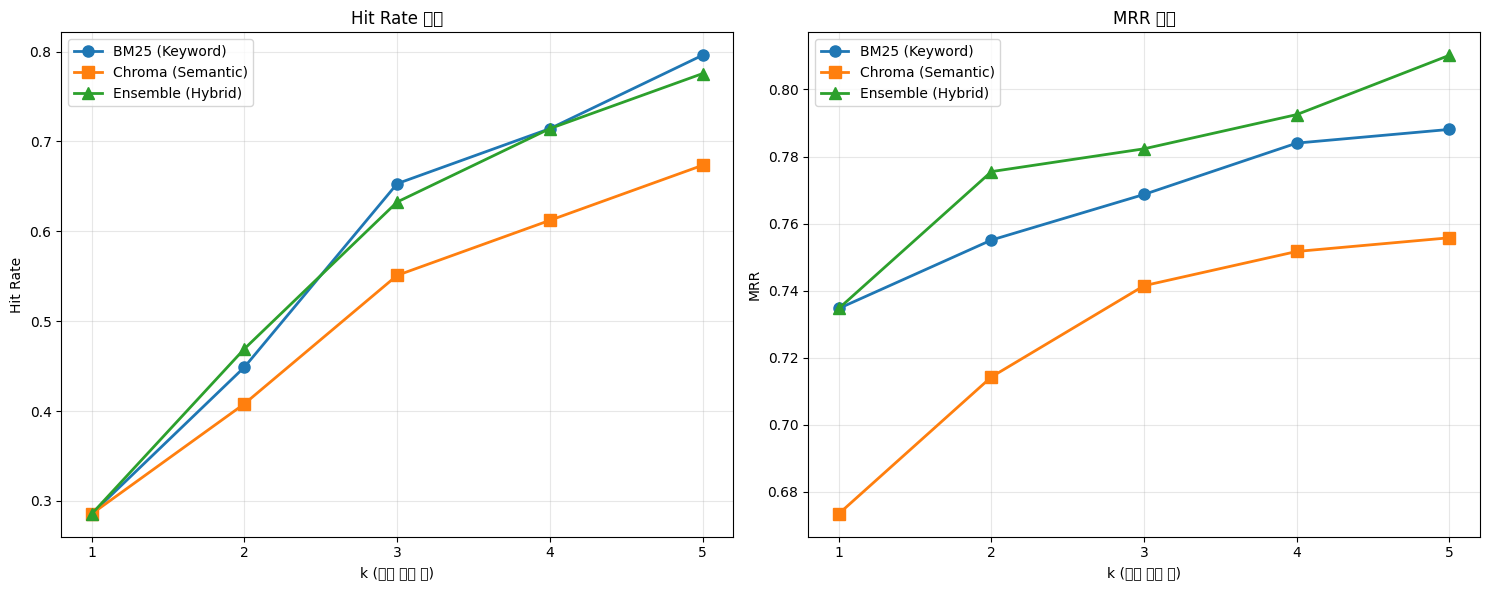


=== 최고 성능 분석 ===
Ensemble 최고 Hit Rate: k=5.0, Hit Rate=0.776
Ensemble 최고 MRR: k=5.0, MRR=0.810


In [50]:
# 결과 비교 및 시각화
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 결과 데이터 수집
results_comparison = pd.DataFrame({
    'k': [1, 2, 3, 4, 5],
    'BM25_Hit_Rate': [result_bm25_k1['hit_rate'], result_bm25_k2['hit_rate'], 
                      result_bm25_k3['hit_rate'], result_bm25_k4['hit_rate'], result_bm25_k5['hit_rate']],
    'BM25_MRR': [result_bm25_k1['mrr'], result_bm25_k2['mrr'], 
                 result_bm25_k3['mrr'], result_bm25_k4['mrr'], result_bm25_k5['mrr']],
    'Chroma_Hit_Rate': [result_chroma_db_k1['hit_rate'], result_chroma_db_k2['hit_rate'], 
                        result_chroma_db_k3['hit_rate'], result_chroma_db_k4['hit_rate'], result_chroma_db_k5['hit_rate']],
    'Chroma_MRR': [result_chroma_db_k1['mrr'], result_chroma_db_k2['mrr'], 
                   result_chroma_db_k3['mrr'], result_chroma_db_k4['mrr'], result_chroma_db_k5['mrr']],
    'Ensemble_Hit_Rate': [result_ensemble_k1['hit_rate'], result_ensemble_k2['hit_rate'], 
                          result_ensemble_k3['hit_rate'], result_ensemble_k4['hit_rate'], result_ensemble_k5['hit_rate']],
    'Ensemble_MRR': [result_ensemble_k1['mrr'], result_ensemble_k2['mrr'], 
                     result_ensemble_k3['mrr'], result_ensemble_k4['mrr'], result_ensemble_k5['mrr']]
})

print("=== 검색 성능 비교 결과 ===")
print(results_comparison.round(3))

# 성능 차트 그리기
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Hit Rate 비교
ax1.plot(results_comparison['k'], results_comparison['BM25_Hit_Rate'], 'o-', label='BM25 (Keyword)', linewidth=2, markersize=8)
ax1.plot(results_comparison['k'], results_comparison['Chroma_Hit_Rate'], 's-', label='Chroma (Semantic)', linewidth=2, markersize=8)
ax1.plot(results_comparison['k'], results_comparison['Ensemble_Hit_Rate'], '^-', label='Ensemble (Hybrid)', linewidth=2, markersize=8)
ax1.set_xlabel('k (검색 문서 수)')
ax1.set_ylabel('Hit Rate')
ax1.set_title('Hit Rate 비교')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks([1, 2, 3, 4, 5])

# MRR 비교
ax2.plot(results_comparison['k'], results_comparison['BM25_MRR'], 'o-', label='BM25 (Keyword)', linewidth=2, markersize=8)
ax2.plot(results_comparison['k'], results_comparison['Chroma_MRR'], 's-', label='Chroma (Semantic)', linewidth=2, markersize=8)
ax2.plot(results_comparison['k'], results_comparison['Ensemble_MRR'], '^-', label='Ensemble (Hybrid)', linewidth=2, markersize=8)
ax2.set_xlabel('k (검색 문서 수)')
ax2.set_ylabel('MRR')
ax2.set_title('MRR 비교')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

# 최고 성능 분석
print("\n=== 최고 성능 분석 ===")
best_hit_rate = results_comparison.loc[results_comparison['Ensemble_Hit_Rate'].idxmax()]
best_mrr = results_comparison.loc[results_comparison['Ensemble_MRR'].idxmax()]

print(f"Ensemble 최고 Hit Rate: k={best_hit_rate['k']}, Hit Rate={best_hit_rate['Ensemble_Hit_Rate']:.3f}")
print(f"Ensemble 최고 MRR: k={best_mrr['k']}, MRR={best_mrr['Ensemble_MRR']:.3f}")